In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import catboost as catb
from lightgbm import LGBMClassifier
import pickle


from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


import matplotlib.pyplot as plt


from scipy.stats import shapiro

from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
from sklearn.metrics import classification_report

In [3]:
pip install catboost 

Note: you may need to restart the kernel to use updated packages.


In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [7]:
ds_cource_train = 'https://salfa.ru/ds/course_project_train.csv'
ds_cource_test = 'https://salfa.ru/ds/course_project_test.csv'
dstrain = 'https://salfa.ru/ds/training_project_data.csv'

In [8]:
df = pd.read_csv(ds_cource_train)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


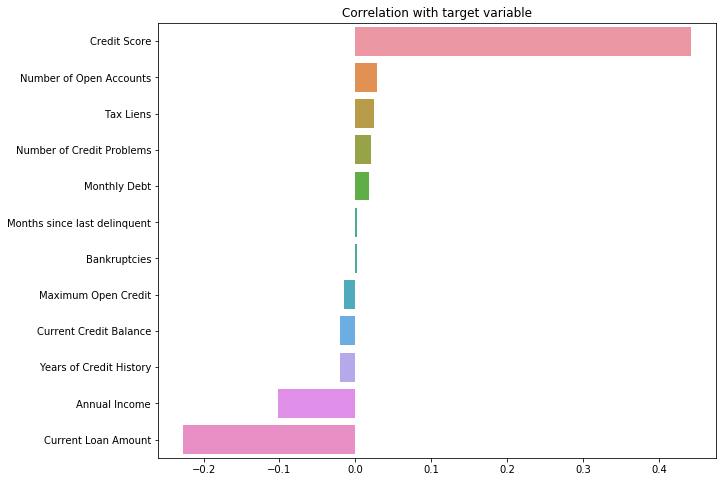

In [9]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(corr_with_target.values, corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

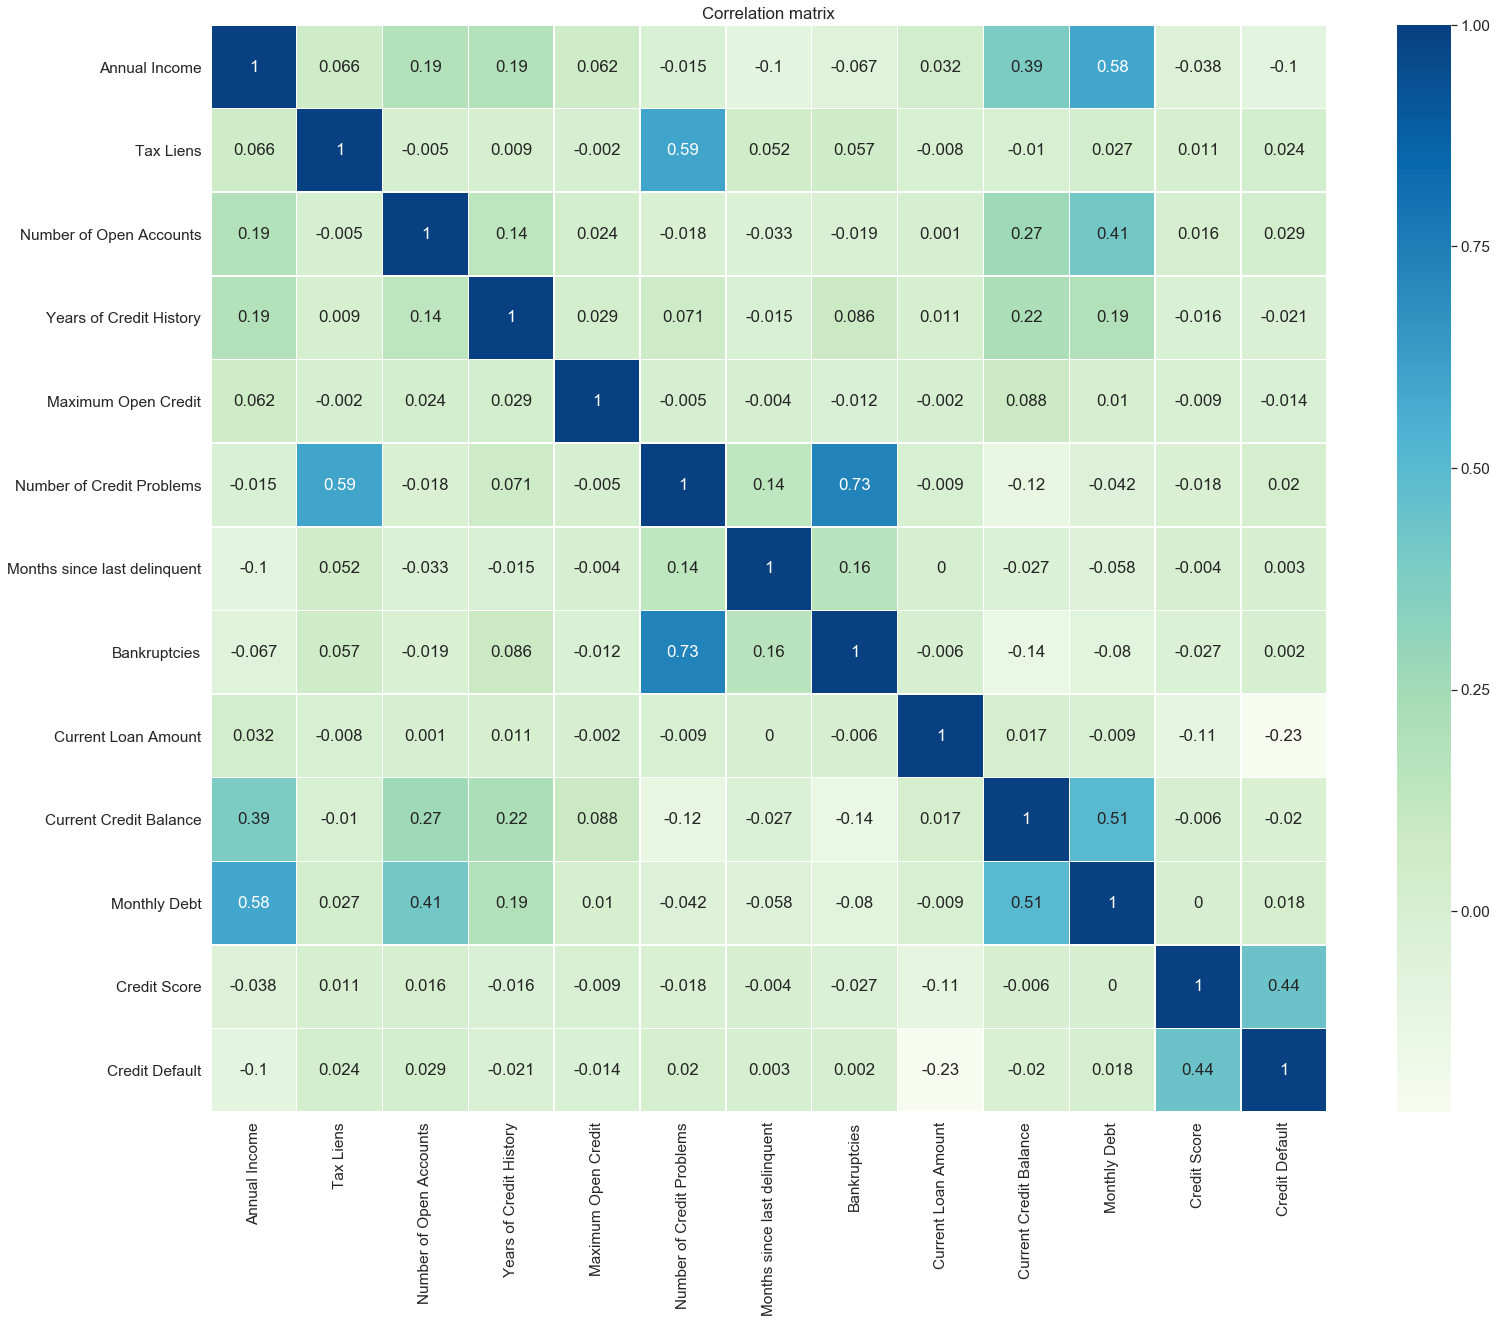

In [10]:
import seaborn as sns
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [11]:
X_col = ['Home Ownership','Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History','Maximum Open Credit', 
         'Number of Credit Problems', 'Months since last delinquent','Bankruptcies','Term', 'Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']


X = df[X_col]
y = df['Credit Default']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 15 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
dtypes: float64(12), object(3)
memory usage: 879.0+ KB


In [12]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Посмотрим пропуски**

In [13]:
X['Years in current job'].value_counts()
    

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [14]:
X['Months since last delinquent'].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
19.0     65
12.0     65
6.0      64
7.0      64
38.0     63
10.0     63
16.0     61
9.0      61
35.0     59
24.0     59
17.0     58
18.0     58
26.0     56
34.0     55
25.0     54
20.0     54
30.0     53
22.0     52
11.0     51
32.0     51
5.0      51
37.0     51
31.0     51
41.0     50
45.0     50
         ..
80.0     28
1.0      26
69.0     26
52.0     26
64.0     26
49.0     25
2.0      25
74.0     25
72.0     24
58.0     24
75.0     24
56.0     23
62.0     23
76.0     23
70.0     22
67.0     22
77.0     21
73.0     21
79.0     20
81.0     19
51.0     19
0.0      18
66.0     17
82.0      4
83.0      3
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [15]:
len(X)-X.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
dtype: int64

In [16]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [17]:
X['Years in current job'].value_counts()


10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [18]:
X['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [19]:
def transformation(X):
   

    X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = X['Bankruptcies'].mode()[0]
    X.loc[X['Current Loan Amount']== 99999999.0, 'Current Loan Amount'] = X['Current Loan Amount'].median()
    X.loc[X['Credit Score'].isna(), 'Credit Score'] = X['Credit Score'].median()
    X.loc[X['Annual Income'].isna(), 'Annual Income'] = X['Annual Income'].median()
    
    
    X['Term'] = X['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int) # Divid into binary features 
    
    X = pd.get_dummies(X, columns = ['Home Ownership'])
    
    
    X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = X['Months since last delinquent'].mode()[0]

    
   # X = pd.get_dummies(X, columns = ['Purpose']) # Ухудшил
    
    
    X.loc[X['Years in current job'].isna(), 'Years in current job'] = X['Years in current job'].mode()[0]
    X = pd.get_dummies(X, columns = ['Years in current job'])
    
            #     X['Home Mortgage'] = X['Home Ownership'].map({'Home Mortgage':'1', 'Rent':'0', 'Own Home':'0','Have Mortgage':'0'}).astype(int)
            #     X['Rent'] = X['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1', 'Own Home':'0','Have Mortgage':'0'}).astype(int)
            #     X['Own Home'] = X['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'0', 'Own Home':'1','Have Mortgage':'0'}).astype(int)
            #     X['Have Mortgage'] = X['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'0', 'Own Home':'0','Have Mortgage':'1'}).astype(int)
            
            
    
    
    
    return(X)

In [20]:
X = transformation(X)
X

C:\Users\Alfa\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Alfa\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,...,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year
0,482087.0,0.0,11.0,26.3,685960.0,1.0,14.0,1.0,1,309573.0,...,1,0,0,0,0,0,0,0,0,0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,14.0,0.0,0,264968.0,...,1,0,0,0,0,0,0,0,0,0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,14.0,0.0,1,309573.0,...,0,0,0,0,0,0,0,1,0,0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,14.0,1.0,1,121396.0,...,0,0,0,0,0,1,0,0,0,0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,14.0,0.0,1,125840.0,...,0,0,0,0,0,0,0,1,0,0
5,1168386.0,0.0,12.0,14.6,366784.0,0.0,14.0,0.0,0,337304.0,...,0,0,0,0,0,0,1,0,0,0
6,1511108.0,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,1,309573.0,...,1,0,0,0,0,0,0,0,0,0
7,1040060.0,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,1,250888.0,...,1,0,0,0,0,0,0,0,0,0
8,1168386.0,0.0,17.0,15.7,0.0,1.0,14.0,1.0,1,129734.0,...,0,0,0,0,1,0,0,0,0,0
9,1168386.0,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,0,572880.0,...,0,0,0,0,0,0,0,0,0,0


Запустим в цикле функцию qqplot на всю выборку без разделения параметров на качественные и количественные

No handles with labels found to put in legend.


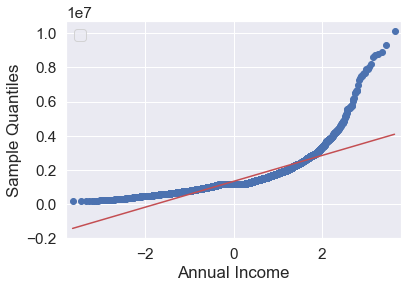

No handles with labels found to put in legend.


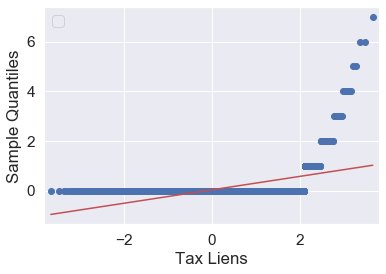

No handles with labels found to put in legend.


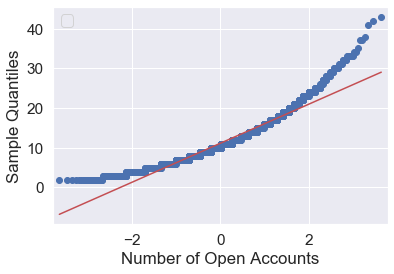

No handles with labels found to put in legend.


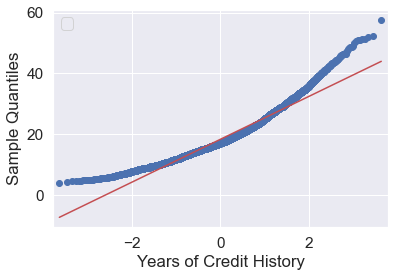

No handles with labels found to put in legend.


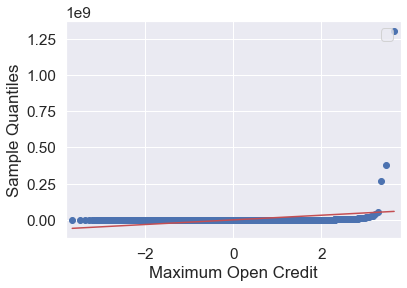

No handles with labels found to put in legend.


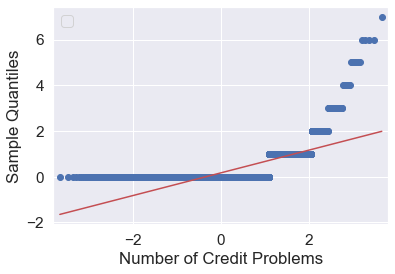

No handles with labels found to put in legend.


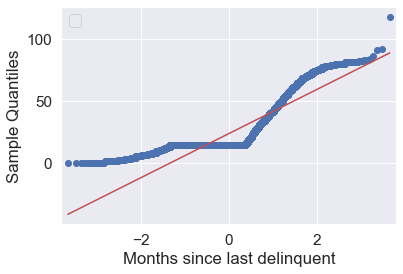

No handles with labels found to put in legend.


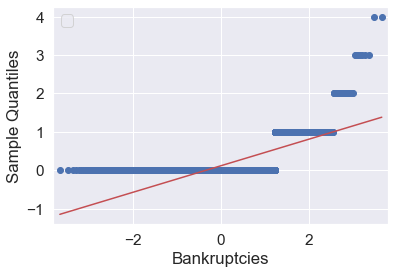

No handles with labels found to put in legend.


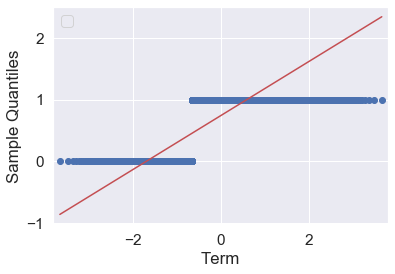

No handles with labels found to put in legend.


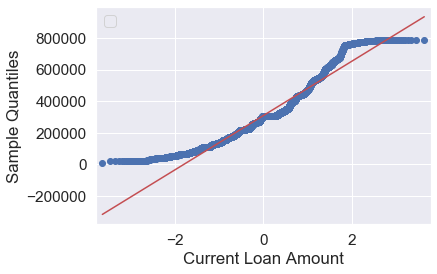

No handles with labels found to put in legend.


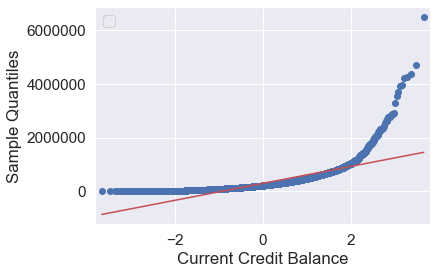

No handles with labels found to put in legend.


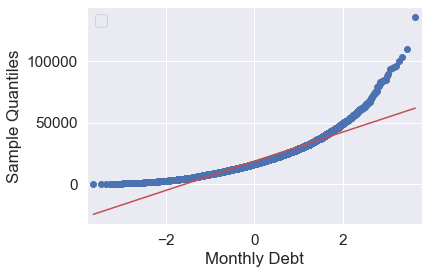

No handles with labels found to put in legend.


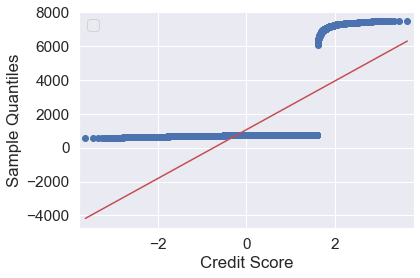

No handles with labels found to put in legend.


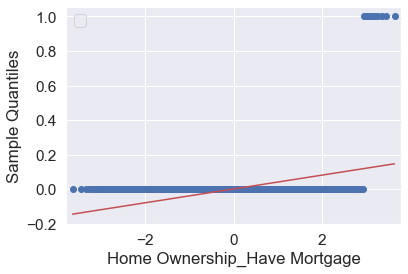

No handles with labels found to put in legend.


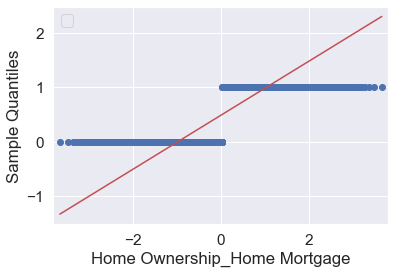

No handles with labels found to put in legend.


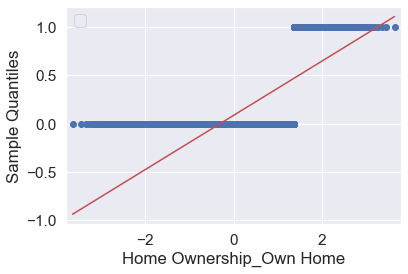

No handles with labels found to put in legend.


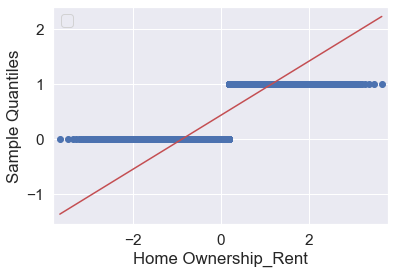

No handles with labels found to put in legend.


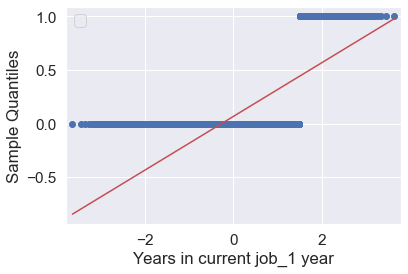

No handles with labels found to put in legend.


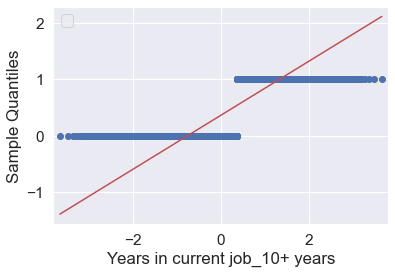

No handles with labels found to put in legend.


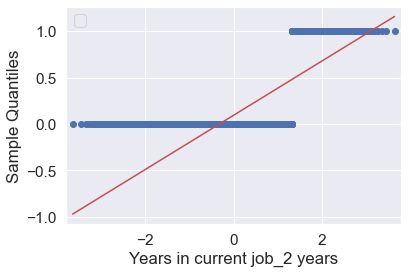

No handles with labels found to put in legend.


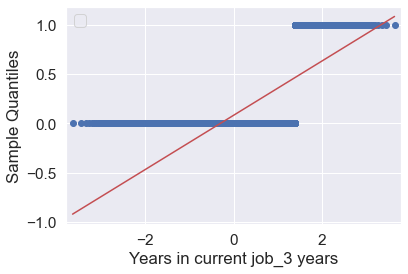

No handles with labels found to put in legend.


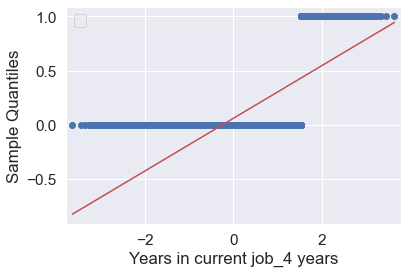

No handles with labels found to put in legend.


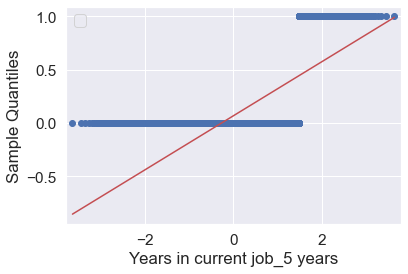

No handles with labels found to put in legend.


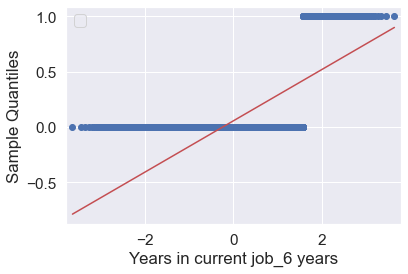

No handles with labels found to put in legend.


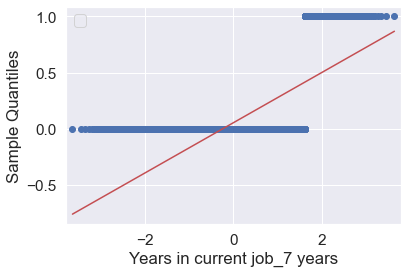

No handles with labels found to put in legend.


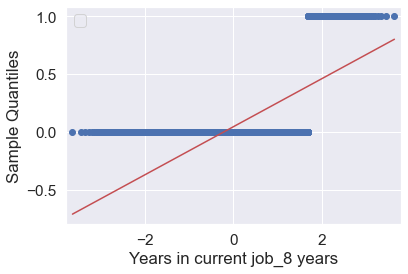

No handles with labels found to put in legend.


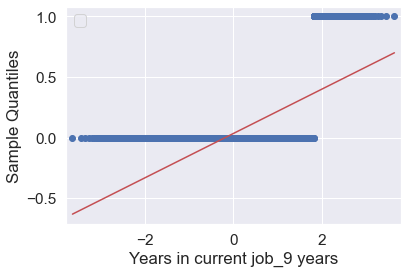

No handles with labels found to put in legend.


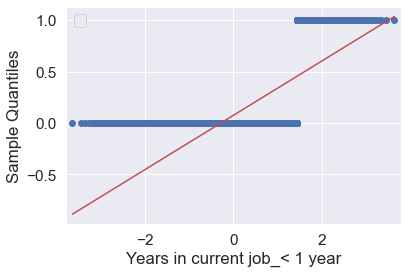

In [21]:

for i in range(X.shape[1]):
    qqplot(X.iloc[:, i], line = 's')
    plt.xlabel(X.columns[i])
    plt.legend()
    plt.show()


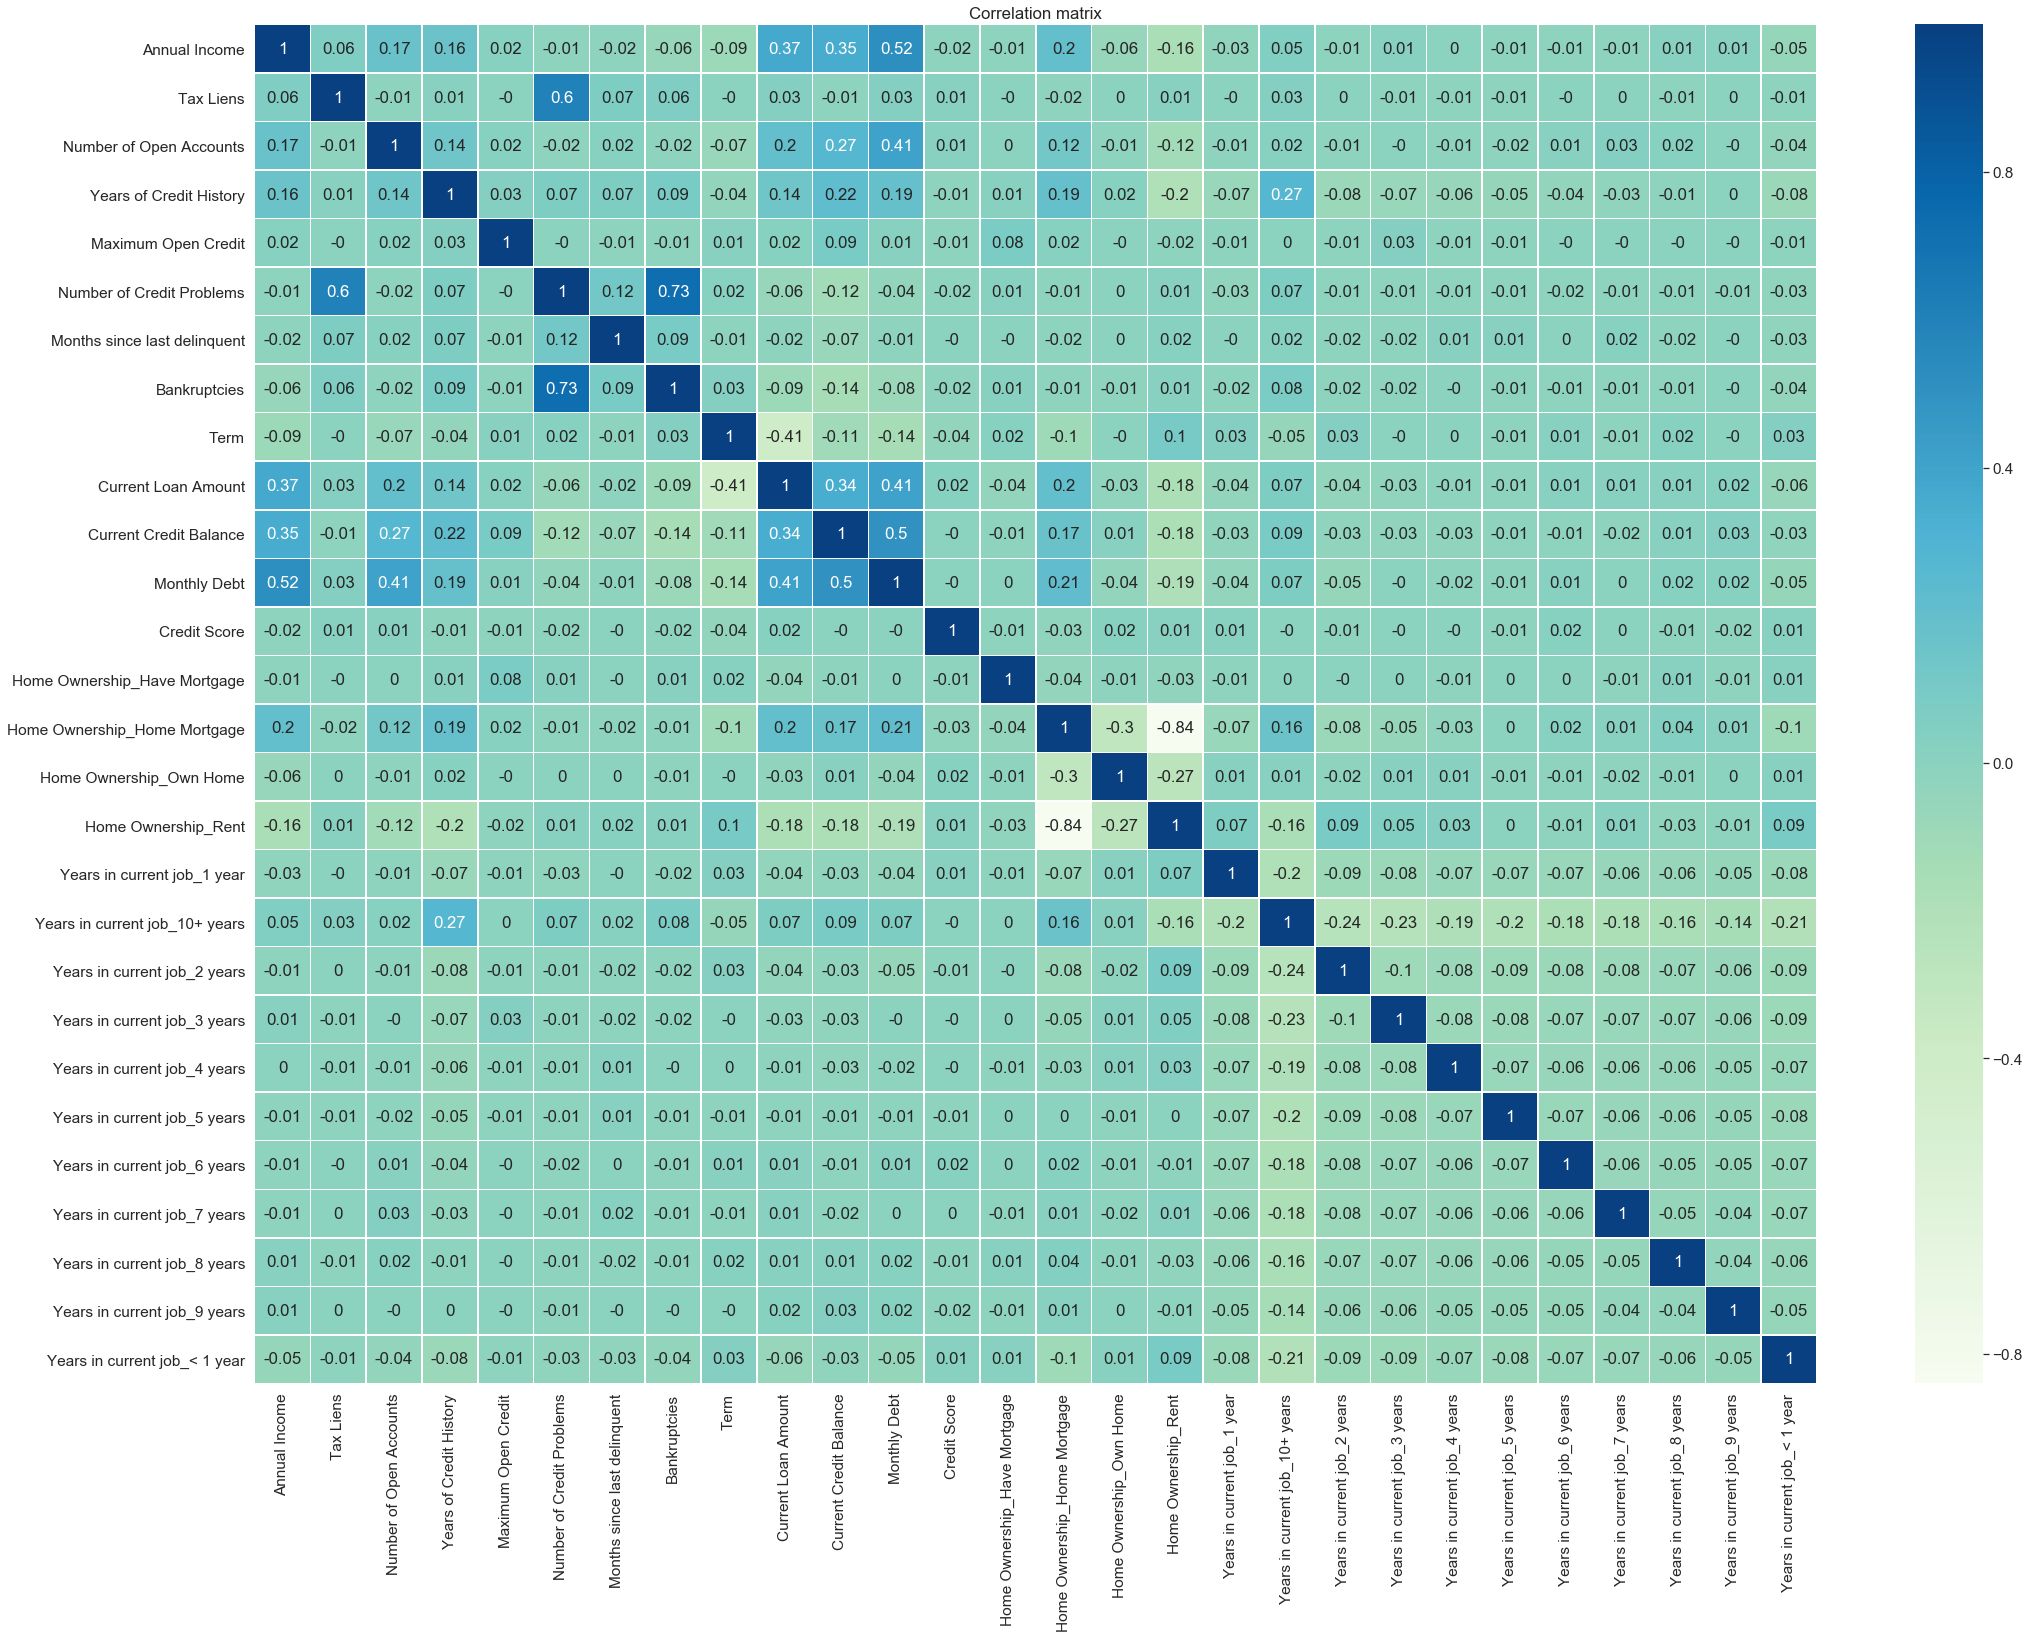

In [22]:
plt.figure(figsize = (35,25))

sns.set(font_scale=1.4)
sns.heatmap(X.corr().round(2), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

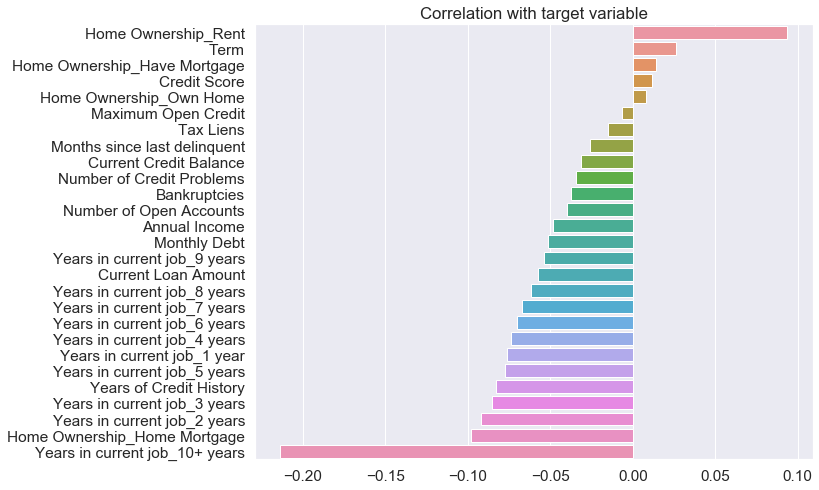

In [23]:
corr_with_target = X.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(corr_with_target.values, corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [24]:
X.describe()


,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,...,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,...,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.325286e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,23.433067,0.116933,0.740800,309088.029067,...,0.360400,0.094000,0.082667,0.062533,0.068800,0.056800,0.052800,0.045200,0.034533,0.075067
std,7.567551e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,17.906245,0.346904,0.438225,171393.740131,...,0.480148,0.291848,0.275396,0.242138,0.253131,0.231475,0.223649,0.207756,0.182607,0.263516
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,11242.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,14.000000,0.000000,0.000000,180169.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,14.000000,0.000000,1.000000,309567.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.499974e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,1.000000,396929.500000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000,789030.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
len(X)-X.count()

Annual Income                     0
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                      0
Term                              0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                      0
Home Ownership_Have Mortgage      0
Home Ownership_Home Mortgage      0
Home Ownership_Own Home           0
Home Ownership_Rent               0
Years in current job_1 year       0
Years in current job_10+ years    0
Years in current job_2 years      0
Years in current job_3 years      0
Years in current job_4 years      0
Years in current job_5 years      0
Years in current job_6 years      0
Years in current job_7 years      0
Years in current job_8 years      0
Years in current job_9 years      0
Years in current job_< 1 yea

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

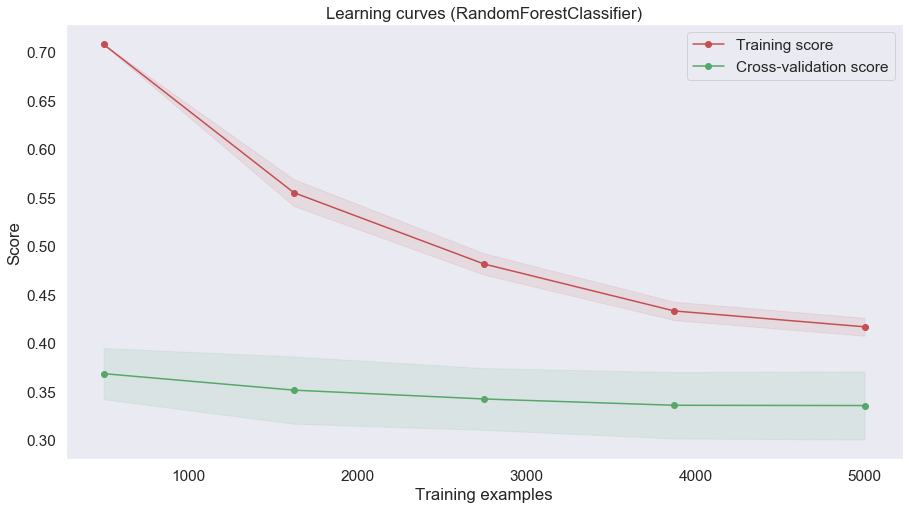

In [27]:
rf = RandomForestClassifier(max_depth=8, random_state=0)
show_learning_curve_plot(rf, X, y)

In [28]:
final_model = catb.CatBoostClassifier(n_estimators=400, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)

In [29]:
rf = RandomForestClassifier(max_depth=10, random_state=0)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
get_classification_report(y_train, y_pred_train,y_test, y_pred_test)


TRAIN

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      3631
           1       0.99      0.38      0.55      1394

    accuracy                           0.83      5025
   macro avg       0.90      0.69      0.72      5025
weighted avg       0.86      0.83      0.80      5025

TEST

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1756
           1       0.88      0.24      0.38       719

    accuracy                           0.77      2475
   macro avg       0.82      0.61      0.62      2475
weighted avg       0.80      0.77      0.72      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1733   23
1                547  172


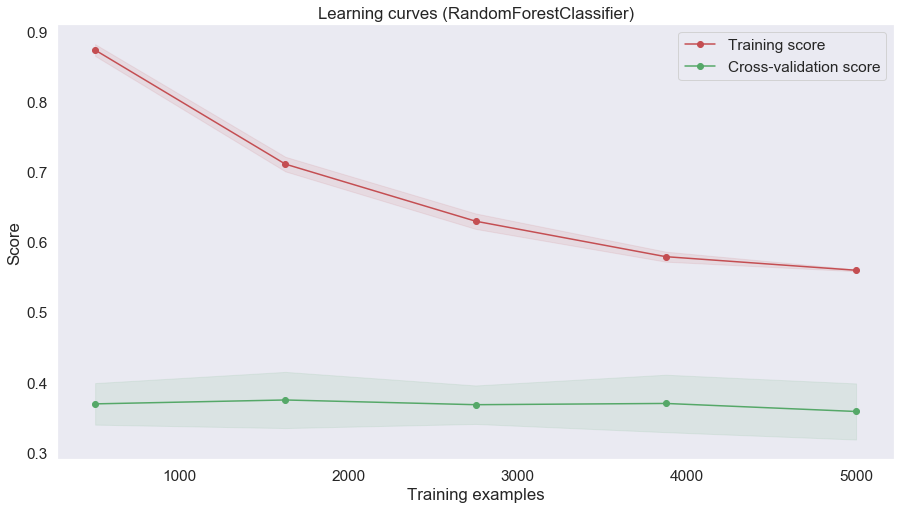

In [30]:
show_learning_curve_plot(rf, X, y)

In [31]:
cb = catb.CatBoostClassifier(n_estimators=400, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)
cb.fit(X_train, y_train)

y_train_pred = cb.predict(X_train)
y_test_pred = cb.predict(X_test)
y_test_pred_probs = cb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.63      0.75      3631
           1       0.47      0.87      0.61      1394

    accuracy                           0.69      5025
   macro avg       0.70      0.75      0.68      5025
weighted avg       0.80      0.69      0.71      5025

TEST

              precision    recall  f1-score   support

           0       0.85      0.58      0.69      1756
           1       0.42      0.75      0.54       719

    accuracy                           0.63      2475
   macro avg       0.64      0.67      0.61      2475
weighted avg       0.73      0.63      0.65      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1017  739
1                179  540


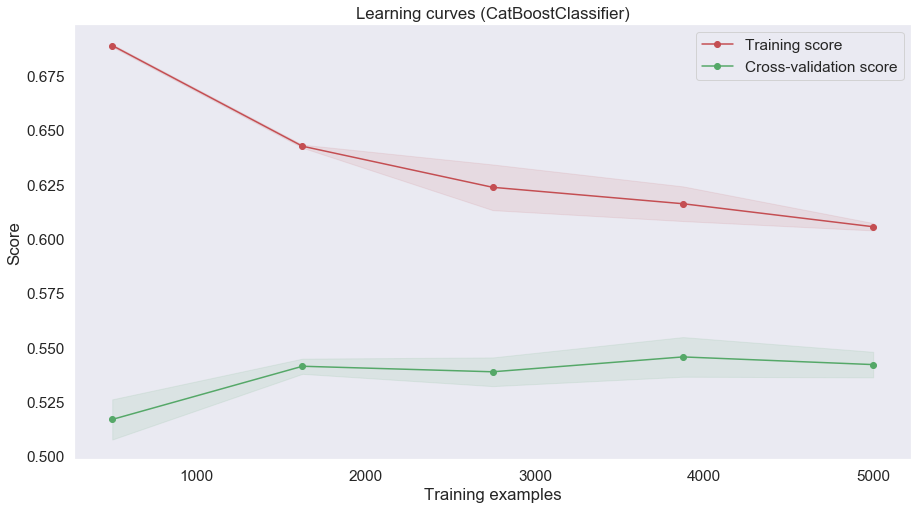

In [32]:
show_learning_curve_plot(cb, X, y)

In [69]:
final_model = catb.CatBoostClassifier(n_estimators=400, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.63      0.75      3631
           1       0.47      0.87      0.61      1394

    accuracy                           0.69      5025
   macro avg       0.70      0.75      0.68      5025
weighted avg       0.80      0.69      0.71      5025

TEST

              precision    recall  f1-score   support

           0       0.85      0.58      0.69      1756
           1       0.42      0.75      0.54       719

    accuracy                           0.63      2475
   macro avg       0.64      0.67      0.61      2475
weighted avg       0.73      0.63      0.65      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1017  739
1                179  540


In [66]:
import  csv

In [56]:
result = pd.read_csv(ds_cource_test)
result = transformation(result[X_col])

C:\Users\Alfa\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [107]:
final_model = catb.CatBoostClassifier(n_estimators=400, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_result = final_model.predict(result)


In [108]:
y_test_pred_probs = pd.DataFrame(y_result, columns = ['DEFAULTS'])

In [110]:
filename  = 'Akatov.csv'
y_test_pred_probs.to_csv(filename, index=0)